In [ ]:
#default_exp data

In [ ]:
# export

from fastcore.dispatch import *
from fastai.data.all import *
from fastai.vision.all import *
from drone_detector.imports import *
from drone_detector.visualizations import *
from drone_detector.utils import *
from matplotlib.cm import ScalarMappable

/home/mayrajeo/miniconda3/envs/dronedetector/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
#hide
from nbdev.showdoc import *

# Custom data used in remote sensing

> Multi- and hyperspectral images, continuous masks, image time series

## Opening functions

In [ ]:
# export

def open_npy(fn, chans=None, max_val=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    if max_val is not None: im = np.clip(im, 0, max_val)
    return im

def open_geotiff(fn, chans=None, max_val=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    if max_val is not None: im = np.clip(im, 0, max_val)
    return im

## show_* functions

In [ ]:
# export

def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, norm_min=None, norm_max=None, scale_axis=(0,1), **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]

    if scale: im = norm(im, norm_min, norm_max, scale_axis)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None, 
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], norm_min=tempim[channel].min(), norm_max=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_mean_spectra(img, ax=None, figsize=(3,3), ctx=None, title=None, **kwargs) -> plt.Axes:
    "Show average spectra graph"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    tempim = img.data.cpu().numpy()
    means = np.nanmean(tempim, axis=(-2, -1))
    ax.plot(means, **kwargs)
    ax.grid(True)
    if title is not None: ax.set_title(title)
    return ax
        
def norm(vals, norm_min=None, norm_max=None, axis=(0,1)):
    """
    For visualization purposes scale image with `(vals-norm_min)/(norm_max-norm_min), 
    with norm_min and norm_max either specified or within 0.01 and 0.99 quantiles of all values
    """
    norm_min = ifnone(norm_min, np.quantile(vals, 0.01, axis=axis))
    norm_max = ifnone(norm_max, np.quantile(vals, 0.99, axis=axis))
    ret_im = (vals - norm_min)/(norm_max-norm_min)
    ret_im[ret_im < 0] = 0
    ret_im[ret_im > 1] = 1
    return ret_im

In [ ]:
#export

@typedispatch
def show_results(x:TensorImage, y:TensorMask, samples, outs, ctxs, max_n=6,
                 nrows=None, ncols=3, figsize=None, show_cbar=False, **kwargs):
    "Patch `show_results` to show segmentation results in three columns (no-mask, ground truth, prediction)"
    
    if ctxs is None: ctxs = get_grid(min(len(samples)*3, max_n*3), nrows=int(min(len(samples), max_n)), 
                                     ncols=3, add_vert=1, figsize=figsize, double=False, 
                                     title='Image/Target/Prediction')
        
    for i in range(2):
        ctxs[::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0), ctxs[::3],range(3*max_n))]
        ctxs[1::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i), ctxs[1::3],range(2*max_n))]
    
    for o in [samples,outs]:
        ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(o.itemgot(0),ctxs[2::3], range(2*max_n))]
    
    if isinstance(y, RegressionMask) and show_cbar:
        ctxs[1::3] = [plt.colorbar(ScalarMappable(cmap='viridis'), ax=c) for c, _ in zip(ctxs[1::3], range(2*max_n))]
        ctxs[2::3] = [plt.colorbar(ScalarMappable(cmap='viridis'), ax=c) for c, _ in zip(ctxs[2::3], range(2*max_n))]

    return ctxs



In [ ]:
#export

@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None,
               show_cbar=False, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples*2), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize,
                                     double=False, title='Image/Target')        
        
    for i in range(2):
        ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0), ctxs[::2],range(2*max_n))]
        ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i), ctxs[1::2],range(2*max_n))]
        
    
    if isinstance(y, RegressionMask) and show_cbar:
        ctxs[1::2] = [plt.colorbar(ScalarMappable(cmap='viridis'), ax=c) for c, _ in zip(ctxs[1::2], range(2*max_n))]

    return ctxs

## RegressionMask

In [ ]:
#export

class RegressionMask(TensorMask):
    "Class for regression segmentation tasks"
    _show_args = ArrayImage._show_args

    def show(self, ctx=None, **kwargs):
        if 'channels' in kwargs.keys(): kwargs.pop('channels')
        return super().show(ctx=ctx, **kwargs)

    @classmethod
    def create(cls, fn:(Path,str,ndarray), **kwargs) ->None:
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray):
            return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **kwargs))
        
        
RegressionMask.create = Transform(RegressionMask.create) 

def RegressionMaskBlock(cls=RegressionMask, **kwargs): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create))

## MultiChannelTensorImage

In [ ]:
# export 

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[0], ctx=None, norm_min=None, norm_max=None, **kwargs):
        "These need refactoring maybe"
        if channels == 'spectra':
            return show_mean_spectra(self, ctx=ctx,  **kwargs)
        if len(channels) == 3: 
            return show_composite(self, channels=channels, ctx=ctx, norm_min=norm_min, norm_max=norm_max,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(self, channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})
        
    @classmethod
    def create(cls, fn:(Path,str,ndarray), chans=None,  max_val=None, **kwargs) ->None:
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray): 
            im = torch.from_numpy(fn)
            if chans is not None: im = im[chans]
            return cls(im)
        if isinstance(fn, Path) or isinstance(fn, str):
            if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans, max_val=max_val))
            elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans, max_val=max_val))
        
    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'
    
MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create) 

In [ ]:
#export
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None, max_val=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans, maxval=max_val))

In [ ]:
#export
def _using_attr(f, attr, x):
    return f(getattr(x,attr))

def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

## MultiChannelTensorImageTuple

In [ ]:
# export

class MultiChannelTensorImageTuple(fastuple):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[0], ctx=None, norm_min=None, norm_max=None, **kwargs):
        ims = self
        "These need refactoring maybe"
        if channels == 'spectra':
            return show_mean_spectra(torch.cat(ims, dim=2), ctx=ctx,  **kwargs)
        if len(channels) == 3: 
            return show_composite(torch.cat(ims, dim=2), channels=channels, ctx=ctx, norm_min=norm_min, norm_max=norm_max,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(torch.cat(ims, dim=2), channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(torch.cat(ims, dim=2), channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})
        
    @classmethod
    def create(cls, fns, chans=None, max_val=None, **kwargs) ->None:
        return cls(tuple(MultiChannelTensorImage.create(f, chans=chans, max_val=max_val) for f in fns))
        
    def __repr__(self): return f'{self.__class__.__name__} of {len(self)} images'
    
MultiChannelTensorImageTuple.create = Transform(MultiChannelTensorImageTuple.create) 

In [ ]:
#export
def MultiChannelImageTupleBlock(cls=MultiChannelTensorImageTuple, chans=None, max_val=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans, max_val=max_val))

In [ ]:
#export

@typedispatch
def show_batch(x:MultiChannelTensorImageTuple, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples*2), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize,
                                     double=False, title='Image/Target')        
        
    for i in range(2):
        ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0), ctxs[::2],range(2*max_n))]
        ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i), ctxs[1::2],range(2*max_n))]

    return ctxs

With `MultiChannelTensorImageTuple` it's easy to process time series of images:

In [ ]:

fns = ['example_data/monthly_data/may/R10C15.tif',
       'example_data/monthly_data/june/R10C15.tif',
       'example_data/monthly_data/july/R10C15.tif',
       'example_data/monthly_data/august/R10C15.tif',
       'example_data/monthly_data/september/R10C15.tif',
       'example_data/monthly_data/october/R10C15.tif']
fns = [Path(f) for f in fns]

In [ ]:
temporaltuple = MultiChannelTensorImageTuple.create(fns)
temporaltuple

MultiChannelTensorImageTuple of 6 images

<AxesSubplot:>

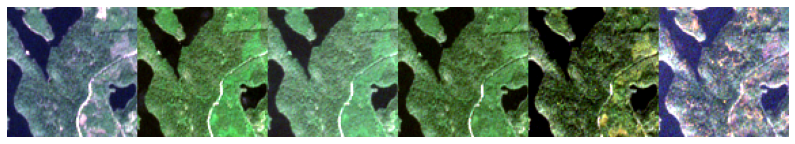

In [ ]:
temporaltuple.show(channels=[3,2,1], figsize=(14,10), cmap='RdYlGn_r')

With this kind of transform `MultiChannelTensorImageTuple` can be transformed into sequence of individual images

In [ ]:
class TupleToTemporal(Transform):
    order = 0
    
    def __init__(self, split_idx=None): store_attr()
        
    def encodes(self, o:MultiChannelTensorImageTuple):
        return torch.stack(o)
    
    def decodes(self, o:MultiChannelTensorImage):
        return torch.unbind(o)

In [ ]:
tfm = TupleToTemporal()

In [ ]:
stacked = tfm.encodes(temporaltuple)
stacked

MultiChannelTensorImage size=6x12x96x96

In [ ]:
unstacked = tfm.decodes(stacked)
unstacked 

(MultiChannelTensorImage size=12x96x96,
 MultiChannelTensorImage size=12x96x96,
 MultiChannelTensorImage size=12x96x96,
 MultiChannelTensorImage size=12x96x96,
 MultiChannelTensorImage size=12x96x96,
 MultiChannelTensorImage size=12x96x96)

<AxesSubplot:>

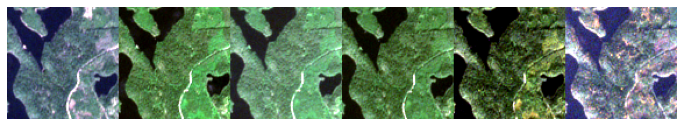

In [ ]:
MultiChannelTensorImageTuple(unstacked).show(channels=[3,2,1], figsize=(12,6))

Most of fastai transforms work out of the box

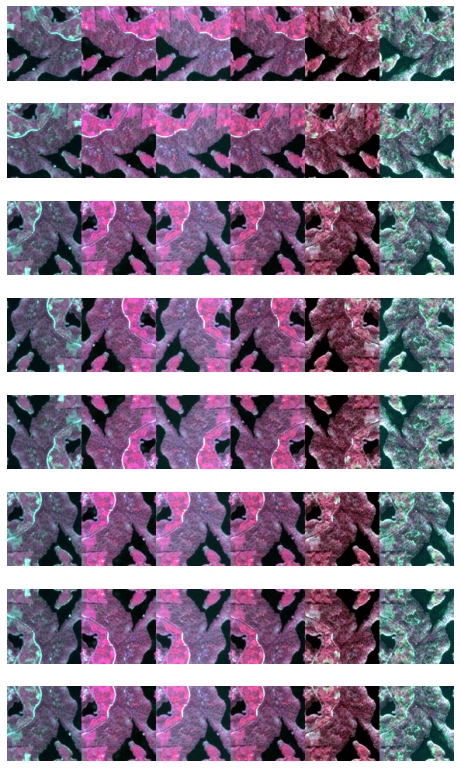

In [ ]:
_, axs = subplots(8,1, figsize=(8,14))
for k, ax in zip(range(0,8), axs.flatten()):
    DihedralItem(p=1)(temporaltuple, split_idx=0).show(channels=[7,3,2], ctx=ax, figsize=(1,6))

In [ ]:
#export

def get_image_timeseries(path, months, masks):
    months.append(masks)
    ls = [[path/m/f for m in months] for f in os.listdir(path/months[0]) if f.endswith('.tif')]
    return ls
    
def get_all_but_last(t): 
    return t[:-1]
def get_last(t): 
    return t[-1]

In [ ]:
path = Path('example_data/monthly_data/')
files = get_image_timeseries(path, ['may', 'june', 'july', 'august', 'september', 'october'], 'masks')

dblock = DataBlock(blocks=(MultiChannelImageTupleBlock(max_val=10000), 
                           RegressionMaskBlock),
                   splitter=RandomSplitter(0),
                   get_items=lambda x: x,
                   get_x=get_all_but_last, get_y=get_last,
                   item_tfms=[
                   ],
                   batch_tfms=[ 
                   ])

In [ ]:
dls = dblock.dataloaders(files[:1], bs=1)

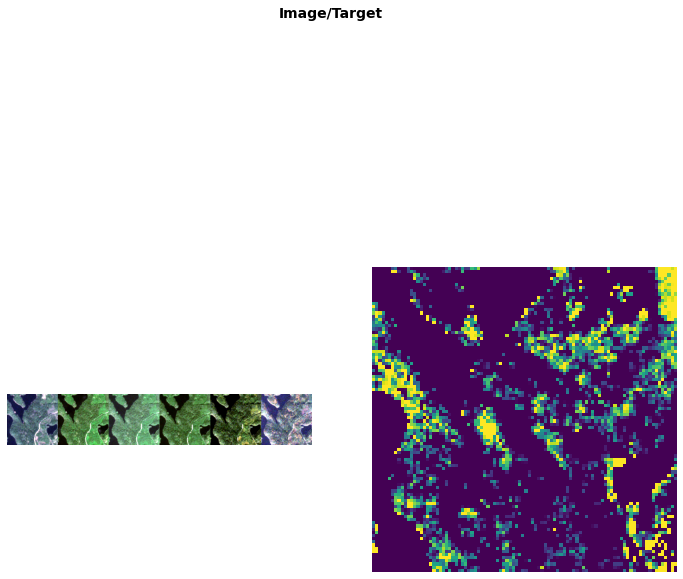

In [ ]:
dls.show_batch(channels=[3,2,1])

## MultiChannelImageDataLoaders

In [ ]:
#export

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, max_val=None, extensions=['.tif'], 
                    train='train', valid='valid', valid_pct=None, seed=None, 
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans, max_val=max_val), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, max_val=None, extensions=['.tif'], 
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.   
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans, max_val=max_val), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)
    
    @classmethod
    def from_name_func(cls, path, fnames, label_func, 
                       chans=None, max_val=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, max_val=max_val, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, max_val=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, max_val=None, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, max_val=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, max_val=max_val **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, max_val=None, valid_pct=0.2, seed=None, 
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans, max_val=max_val), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, max_val=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas (GeoJSON, ESRI Shapefile)
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        # Shapefiles don't support boolean columns
        if 'valid_col' in kwargs.keys(): df[kwargs['valid_col']] = df[kwargs['valid_col']].astype(bool)
        return cls.from_df(df, path=path, chans=chans, max_val=None, **kwargs)
    
    @classmethod
    def from_csv(cls, path,  chans=None, max_val=None, csv_fname='labels.csv', 
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, max_val=None, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels, chans=None, max_val=None, valid_pct=0.2, 
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`.
        Optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans, max_val=max_val), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
    
MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_folder)

<h4 id="MultiChannelImageDataLoaders.from_folder" class="doc_header"><code>MultiChannelImageDataLoaders.from_folder</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_folder</code>(**`path`**, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`extensions`**=*`['.tif']`*, **`train`**=*`'train'`*, **`valid`**=*`'valid'`*, **`valid_pct`**=*`None`*, **`seed`**=*`None`*, **`vocab`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
Optionally list the channels to use.

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_path_func)

<h4 id="MultiChannelImageDataLoaders.from_path_func" class="doc_header"><code>MultiChannelImageDataLoaders.from_path_func</code><a href="__main__.py#L20" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_path_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`extensions`**=*`['.tif']`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`s with `label_func`.   
Optionally list the channels to use.

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_name_func)

<h4 id="MultiChannelImageDataLoaders.from_name_func" class="doc_header"><code>MultiChannelImageDataLoaders.from_name_func</code><a href="__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_name_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`extensions`**=*`['.tif']`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from name attrs in list of `fnames` in `path`s with `label_func`.
Optionally list the channels to use.

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_shapefile)

<h4 id="MultiChannelImageDataLoaders.from_shapefile" class="doc_header"><code>MultiChannelImageDataLoaders.from_shapefile</code><a href="__main__.py#L73" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_shapefile</code>(**`path`**, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`shp_fname`**=*`'labels.shp'`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`fn_col`**=*`0`*, **`folder`**=*`None`*, **`suff`**=*`''`*, **`label_col`**=*`1`*, **`label_delim`**=*`None`*, **`y_block`**=*`None`*, **`valid_col`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from shapefile `shp_fname` in `path` readable with geopandas.
Optionally list the channels to use.

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_lists)

<h4 id="MultiChannelImageDataLoaders.from_lists" class="doc_header"><code>MultiChannelImageDataLoaders.from_lists</code><a href="__main__.py#L88" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_lists</code>(**`path`**, **`fnames`**, **`labels`**, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`valid_pct`**=*`0.2`*, **`seed`**:`int`=*`None`*, **`y_block`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`.
Optionally list the channels to use.

## TifSegmentationDataLoaders

In [ ]:
#export
class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, y_block=MaskBlock, chans=None, max_val=None,
                         extensions=['.tif'], valid_pct=0.2, seed=None, splitter=None,
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        splitter = RandomSplitter(valid_pct, seed=seed) if splitter is None else splitter
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans, max_val=max_val), 
                                   y_block(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
# export

def label_with_matching_fname(fn, path): 
    "Utility to match image and mask that have different folder but identical filename"
    return f'{path}/{fn.stem}{fn.suffix}'

In [ ]:
show_doc(TifSegmentationDataLoaders.from_label_func)

<h4 id="TifSegmentationDataLoaders.from_label_func" class="doc_header"><code>TifSegmentationDataLoaders.from_label_func</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>TifSegmentationDataLoaders.from_label_func</code>(**`path`**, **`fnames`**, **`label_func`**, **`y_block`**=*`MaskBlock`*, **`chans`**=*`None`*, **`max_val`**=*`None`*, **`extensions`**=*`['.tif']`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`splitter`**=*`None`*, **`codes`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from list of `fnames` in `path`s with `label_func`.

## Transforms

In [ ]:
#export

class ScaleToFloatTensor(Transform):
    "Scale image values to interval 0-1"
    order = 10
    
    def __init__(self, div=100., div_mask=1, split_idx=None):
        super().__init__(split_idx=split_idx)
        self.div, self.div_mask = div, div_mask
        
    def encodes(self, o:TensorImage): return o.float().div_(self.div)
    def decodes(self, o:TensorImage): return o * self.div if self.div else o